In [1]:
import menpo.io as mio
from menpo.visualize import print_progress

ImportError: DLL load failed: The specified module could not be found.

In [2]:
path_to_train = r'data\FERET_pr_train'
training_images = list()
for img in print_progress(mio.import_images(path_to_train, verbose=True)):
    if img.n_channels == 3:
        img = img.as_greyscale()
    img = img.crop_to_landmarks_proportion(0.2)
    d = img.diagonal()
    if d > 400:
        img = img.rescale(400.0 / d)
    training_images.append(img)

Found 99 assets, index the returned LazyList to import.
[====================] 100% (99/99) - done.                                     


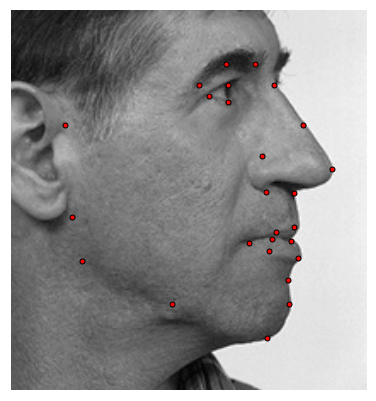

In [3]:
%matplotlib inline
from menpowidgets import visualize_images
visualize_images(training_images)

In [4]:
import random
path_to_test = r'data\display'
profile_images = list()
frontal_images = list()
for img in print_progress(mio.import_images(path_to_test, verbose=True)):
    if 'pr' in str(img.path):
        profile_images.append(img)
    else:
        frontal_images.append(img)

Found 4 assets, index the returned LazyList to import.
[====================] 100% (4/4) - done.                                       


In [5]:
from menpodetect.dlib import train_dlib_detector
from menpodetect.dlib import DlibDetector

in_memory_detector = train_dlib_detector(training_images, verbose_stdout=True)
profile_detector = DlibDetector(in_memory_detector)
for img in profile_images:
    profile_detector(img)

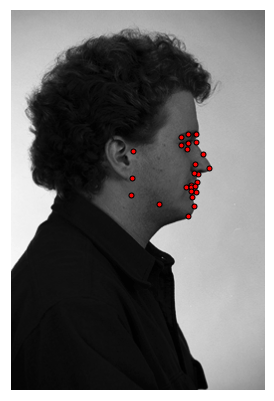

In [6]:
%matplotlib inline
from menpowidgets import visualize_images
visualize_images(profile_images)

In [7]:
from menpodetect import load_dlib_frontal_face_detector
detect = load_dlib_frontal_face_detector()
for img in frontal_images:
    detect(img)

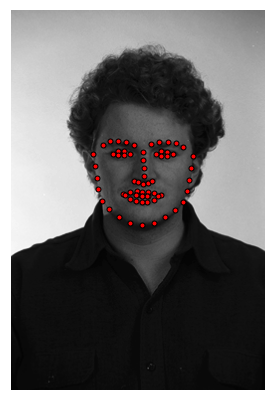

In [8]:
%matplotlib inline
from menpowidgets import visualize_images
visualize_images(frontal_images)

In [9]:
from menpofit.aam import PatchAAM
from menpo.feature import fast_dsift

patch_aam = PatchAAM(training_images, group='PTS', patch_shape=[(15, 15), (23, 23)],
                     diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
                     max_shape_components=20, max_appearance_components=150,
                     verbose=True)

- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (99/99) - done.                    
  - Scale 0: Doneding appearance model                                          ing
  - Scale 1: Doneding appearance model                                          
                                                              

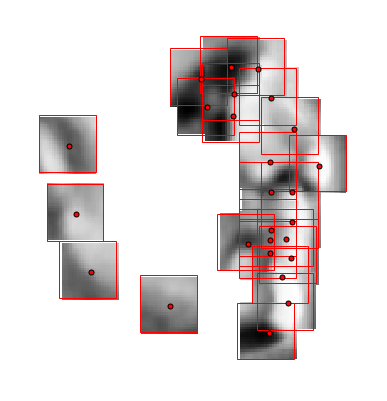

In [10]:
%matplotlib inline
patch_aam.view_appearance_models_widget()

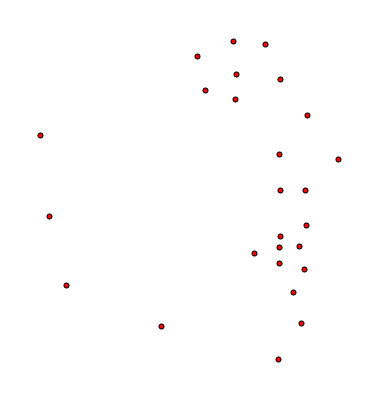

In [11]:
%matplotlib inline
patch_aam.view_shape_models_widget()

In [12]:
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional

fitter = LucasKanadeAAMFitter(patch_aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])

In [13]:
result_imgs = []
for img in print_progress(profile_images):
    bbox = profile_detector(img)[0]
    result = fitter.fit_from_bb(img, bbox, max_iters=[15, 5])
    result_imgs.append(result)
    img.landmarks['PTS'] = result.final_shape

[====================] 100% (2/2) - done.                                       


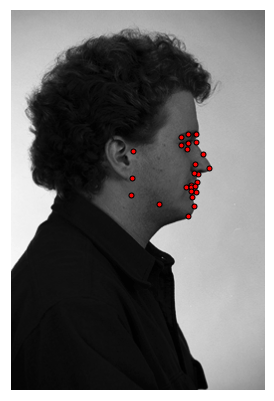

In [14]:
%matplotlib inline
from menpowidgets import visualize_images
visualize_images(profile_images)

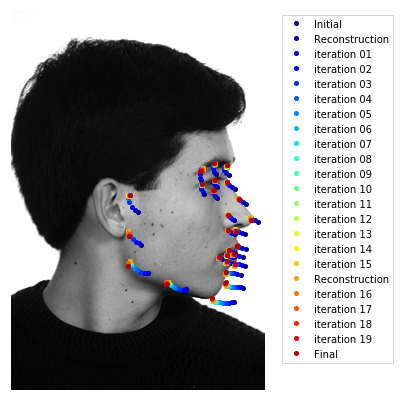

In [15]:
result_imgs[1].view_iterations()

In [27]:
import collections
import os
# from menpo.landmark import LandmarkGroup

lls = []
for n in range(26):
    lls.append(True)
diction = collections.OrderedDict()
diction['PTS'] = lls

path_list = [os.path.basename(str(img.path)) for img in profile_images]
for i, img in enumerate(result_imgs):
    landmarks = img.final_shape
#     lgroup = LandmarkGroup(landmarks, diction)
    file_name = path_list[i].replace('.tif', '.pts')
    mio.export_landmark_file(landmarks, os.path.join(path_to_test, file_name), extension='pts', overwrite=True)

In [22]:
a = result_imgs[0]

In [23]:
a.final_shape

PointCloud: n_points: 26, n_dims: 2